This notebook provides an interactive way to explore your glucose tracking data and create customized reports.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.lines as mlines
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime, timedelta, time

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Configuration
DATA_DIR = Path("/data/sample")
OUTPUT_DIR = Path("/output")
OUTPUT_DIR.mkdir(exist_ok=True)

# Glucose target ranges (mmol/L)
GLUCOSE_TARGET_RANGE = (3.9, 10.0)
GLUCOSE_OPTIMAL_RANGE = (4.0, 7.8)

# Colors for visualization
COLORS = {
    'glucose': '#2E86AB',
    'sleep': '#A23B72',
    'workout': '#F18F01',
    'nutrition': '#C73E1D',
    'target': '#59CD90'
}

In [4]:
# Data loading functions
def load_glucose_data(filepath):
    """Load and preprocess glucose data"""
    df = pd.read_csv(filepath)
    df['Device Timestamp'] = pd.to_datetime(df['Device Timestamp'])
    df = df.set_index('Device Timestamp').sort_index()
    df = df.groupby(level=0).mean()  # Remove duplicates
    df.replace(0, np.nan, inplace=True)
    return df

def load_sleep_data(filepath):
    """Load sleep data"""
    df = pd.read_csv(filepath, sep=';')
    df['Start'] = pd.to_datetime(df['Start'])
    df['End'] = pd.to_datetime(df['End'])
    return df

def load_workout_data(filepath):
    """Load workout data"""
    df = pd.read_csv(filepath)
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    return df

def load_nutrition_data(filepath):
    """Load nutrition data"""
    df = pd.read_csv(filepath)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df = df.set_index('Datetime')
    return df

# Data preprocessing functions
def create_workout_timeline(df_workout, glucose_index):
    """Create workout timeline matching glucose data index"""
    timeline = pd.DataFrame(index=glucose_index)
    timeline['Strength'] = 0
    timeline['Cardio'] = 0
    
    for _, workout in df_workout.iterrows():
        mask = (timeline.index >= workout['start_time']) & (timeline.index <= workout['end_time'])
        if workout['workout_type'].lower() in ['strength', 'weight', 'resistance']:
            timeline.loc[mask, 'Strength'] = 1
        elif workout['workout_type'].lower() in ['cardio', 'running', 'cycling', 'walking']:
            timeline.loc[mask, 'Cardio'] = 1
    
    return timeline

def create_nutrition_timeline(df_nutrition, glucose_index):
    """Create nutrition timeline matching glucose data index"""
    timeline = pd.DataFrame(index=glucose_index)
    timeline['Nutrition'] = 0
    
    # Mark nutrition events (you might want to adjust the time window)
    for nutrition_time in df_nutrition.index:
        # Find closest glucose measurement time
        closest_idx = timeline.index.get_indexer([nutrition_time], method='nearest')[0]
        if closest_idx < len(timeline):
            timeline.iloc[closest_idx, timeline.columns.get_loc('Nutrition')] = 1
    
    return timeline

def interpolate_glucose_data(df_glucose):
    """Interpolate glucose data for smooth visualization"""
    df_interpolated = df_glucose.copy()
    
    # Get the main glucose column (adjust column name as needed)
    glucose_col = 'Historic Glucose mmol/L'  # Adjust this to match your data
    if glucose_col not in df_glucose.columns:
        # Try to find glucose column automatically
        glucose_cols = [col for col in df_glucose.columns if 'glucose' in col.lower() or 'mmol' in col.lower()]
        if glucose_cols:
            glucose_col = glucose_cols[0]
        else:
            raise ValueError("Could not find glucose column in data")
    
    # Interpolate missing values
    df_interpolated['Glucose_interpolated'] = df_interpolated[glucose_col].interpolate(method='time')
    
    return df_interpolated

def create_combined_dataset(df_glucose, df_nutrition, df_workout):
    """Combine all datasets into a single DataFrame"""
    # Start with glucose data
    df_combined = interpolate_glucose_data(df_glucose)
    
    # Add workout timeline
    workout_timeline = create_workout_timeline(df_workout, df_glucose.index)
    df_combined = df_combined.join(workout_timeline)
    
    # Add nutrition timeline
    nutrition_timeline = create_nutrition_timeline(df_nutrition, df_glucose.index)
    df_combined = df_combined.join(nutrition_timeline)
    
    return df_combined

# Utility functions for plotting
def seconds_to_hours_minutes(seconds):
    """Convert seconds to hours:minutes format"""
    if pd.isna(seconds):
        return "N/A"
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    return f"{hours}:{minutes:02d}"

def get_glucose_values(df, column_name):
    """Get interpolated glucose values for events"""
    return df.loc[df[column_name] != 0, 'Glucose_interpolated']

def highlight_period(ax, start, end, label, color='lightblue', alpha=0.3):
    """Highlight a time period on the plot with annotation"""
    ax.axvspan(start, end, alpha=alpha, color=color)
    # Add annotation in the middle of the period
    mid_time = start + (end - start) / 2
    ax.annotate(label, xy=(mid_time, ax.get_ylim()[1] * 0.9), 
                ha='center', va='top', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

def add_nutrition_annotations(ax, day_nutri_points, df_nutri):
    """Add nutrition annotations with alternating positions"""
    texts = []
    
    for idx, (x, y) in enumerate(zip(day_nutri_points.index, day_nutri_points.values)):
        try:
            meal_info = df_nutri.loc[x]
            # Handle different possible column names for macros
            protein = getattr(meal_info, 'P_Macro', getattr(meal_info, 'Protein', 'N/A'))
            fat = getattr(meal_info, 'F_Macro', getattr(meal_info, 'Fat', 'N/A'))
            carbs = getattr(meal_info, 'C_Macro', getattr(meal_info, 'Carbs', 'N/A'))
            meal_name = getattr(meal_info, 'Meal', getattr(meal_info, 'Food', 'Meal'))
            
            annotation_text = f'{meal_name}\n{protein}P | {fat}F | {carbs}C'
            
            if idx % 2 == 0:
                xytext = (-80, -70)
            else:
                xytext = (-80, 55)
                
            texts.append(ax.annotate(
                annotation_text,
                xy=(x, y),
                xytext=xytext,
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', relpos=(1, 0)),
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                fontsize=8
            ))
        except (KeyError, IndexError):
            # Skip annotation if data not available
            continue
    
    return texts

def calculate_statistics(data):
    """Calculate glucose statistics for a day"""
    if len(data) == 0:
        return {col: 0 for col in ['mean', 'median', 'std', 'min', 'max', 'cv', 'tir']}
    
    stats = {
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        'cv': (data.std() / data.mean()) * 100 if data.mean() != 0 else 0
    }
    
    # TIR calculation
    in_range = (3.9 <= data) & (data <= 10)
    if len(data) > 1:
        time_diff = data.index.to_series().diff()
        time_between = time_diff.shift(-1).fillna(pd.Timedelta(0))
        adjusted_time = (time_diff + time_between) / 2
        
        time_in_range = adjusted_time[in_range].sum()
        total_time = adjusted_time.sum()
        stats['tir'] = (time_in_range / total_time) * 100 if total_time > pd.Timedelta(0) else 0
    else:
        stats['tir'] = 0
    
    return stats

def plot_single_day(ax_main, ax_stats, df_combined, df_nutri, df_sleep, plot_date):
    """Plot glucose data for a single day"""
    day_start = datetime.combine(plot_date, time.min)
    day_end = datetime.combine(plot_date, time.max)
    
    # Get the glucose column name
    glucose_col = 'Historic Glucose mmol/L'
    if glucose_col not in df_combined.columns:
        glucose_cols = [col for col in df_combined.columns if 'glucose' in col.lower() or 'mmol' in col.lower()]
        if glucose_cols:
            glucose_col = glucose_cols[0]
    
    # Filter glucose data for the current day
    day_mask = df_combined.index.strftime('%Y-%m-%d') == plot_date.strftime('%Y-%m-%d')
    data = df_combined[day_mask][glucose_col].dropna()
    
    if len(data) == 0:
        ax_main.text(0.5, 0.5, 'No data available for this day', 
                    transform=ax_main.transAxes, ha='center', va='center')
        ax_stats.axis('off')
        return
    
    # Plot main glucose line
    ax_main.plot(data.index, data.values, color='blue', linewidth=1.5, zorder=1)
    
    # Add target range overlay
    rect = patches.Rectangle((day_start, 3.9), day_end - day_start, 10 - 3.9, 
                           facecolor='lightgrey', alpha=0.3, zorder=0)
    ax_main.add_patch(rect)
    
    # Add median line
    median_line = mlines.Line2D([day_start, day_end], [np.median(data), np.median(data)], 
                              color='lightcoral', linewidth=2, alpha=0.7, zorder=2)
    ax_main.add_line(median_line)
    
    # Add nutrition points and annotations
    if 'Nutrition' in df_combined.columns:
        nutri_points = get_glucose_values(df_combined, 'Nutrition')
        day_nutri_points = nutri_points[nutri_points.index.strftime('%Y-%m-%d') == plot_date.strftime('%Y-%m-%d')]
        
        if len(day_nutri_points) > 0:
            ax_main.scatter(day_nutri_points.index, day_nutri_points.values, 
                           color='navy', label='Nutrition', zorder=7, s=50)
            add_nutrition_annotations(ax_main, day_nutri_points, df_nutri)
    
    # Add strength workout data
    if 'Strength' in df_combined.columns:
        strength_points = df_combined.loc[df_combined['Strength'] != 0, 'Glucose_interpolated']
        day_strength_points = strength_points[strength_points.index.strftime('%Y-%m-%d') == plot_date.strftime('%Y-%m-%d')]
        if len(day_strength_points) > 0:
            ax_main.plot(day_strength_points.index, day_strength_points.values, 
                        color='orange', label='Strength', zorder=6, linewidth=3)
    
    # Add cardio workout data
    if 'Cardio' in df_combined.columns:
        cardio_points = df_combined.loc[df_combined['Cardio'] != 0, 'Glucose_interpolated']
        day_cardio_points = cardio_points[cardio_points.index.strftime('%Y-%m-%d') == plot_date.strftime('%Y-%m-%d')]
        if len(day_cardio_points) > 0:
            ax_main.plot(day_cardio_points.index, day_cardio_points.values, 
                        color='red', label='Cardio', zorder=5, linewidth=3)
    
    # Add sleep periods
    for _, sleep in df_sleep.iterrows():
        start = sleep['Start']
        end = sleep['End']
        quality = sleep.get('Sleep Quality', 'N/A')
        time_bed = sleep.get('Time in bed (seconds)', 0)
        time_sleep = sleep.get('Time asleep (seconds)', 0)
        
        sleep_label = f'B:{seconds_to_hours_minutes(time_bed)} | S:{seconds_to_hours_minutes(time_sleep)} | Q:{quality}'
        
        if start.date() == plot_date:
            if end.date() == plot_date:
                highlight_period(ax_main, start, end, sleep_label)
            else:
                ax_main.axvspan(start, day_end, alpha=0.3, color='lightblue')
        elif end.date() == plot_date:
            highlight_period(ax_main, day_start, end, sleep_label)
    
    # Configure axes
    ax_main.set_xlim(day_start, day_end)
    ax_main.set_ylim(data.mean()-6, data.mean()+6)
    
    # Set time formatting
    ax_main.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax_main.xaxis.set_minor_locator(mdates.HourLocator())
    
    # Labels and title
    ax_main.set_title(plot_date.strftime('%A, %Y-%m-%d'), fontsize=12, fontweight='bold')
    ax_main.set_ylabel('Glucose (mmol/L)')
    ax_main.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Statistics subplot
    ax_stats.axis('off')
    stats = calculate_statistics(data)
    
    stats_text = (f"Mean: {stats['mean']:.2f}\n"
                 f"Median: {stats['median']:.2f}\n"
                 f"Std Dev: {stats['std']:.2f}\n"
                 f"Min: {stats['min']:.2f}\n"
                 f"Max: {stats['max']:.2f}\n"
                 f"CV: {stats['cv']:.2f}%\n"
                 f"TIR: {stats['tir']:.2f}%")
    
    ax_stats.text(0.1, 0.5, stats_text, transform=ax_stats.transAxes, 
                 verticalalignment='center', fontsize=10, fontfamily='monospace')

def create_glucose_dashboard(glucose_filepath, nutrition_filepath, workout_filepath, 
                           sleep_filepath, start_date, num_days):
    """Create the complete glucose dashboard from file paths"""
    
    # Load all data
    print("Loading data...")
    df_glucose = load_glucose_data(glucose_filepath)
    df_nutrition = load_nutrition_data(nutrition_filepath)
    df_workout = load_workout_data(workout_filepath)
    df_sleep = load_sleep_data(sleep_filepath)
    
    # Create combined dataset
    print("Processing data...")
    df_combined = create_combined_dataset(df_glucose, df_nutrition, df_workout)
    
    # Set up the figure
    print("Creating plots...")
    fig = plt.figure(figsize=(15, 4 * num_days))
    gs = gridspec.GridSpec(num_days, 2, width_ratios=[5, 1])
    
    # Plot each day
    for i in range(num_days):
        plot_date = start_date + timedelta(days=i)
        
        # Create subplots for this day
        ax_main = fig.add_subplot(gs[i, 0])
        ax_stats = fig.add_subplot(gs[i, 1])
        
        # Plot the day's data
        plot_single_day(ax_main, ax_stats, df_combined, df_nutrition, df_sleep, plot_date)
        
        print(f"Plotted {plot_date.strftime('%Y-%m-%d')}")
    
    plt.tight_layout()
    print("Dashboard created successfully!")
    return fig, df_combined

# Alternative function to work with pre-loaded DataFrames
def create_glucose_dashboard_from_dfs(df_glucose, df_nutrition, df_workout, df_sleep, 
                                    start_date, num_days):
    """Create the complete glucose dashboard from pre-loaded DataFrames"""
    
    # Create combined dataset
    print("Processing data...")
    df_combined = create_combined_dataset(df_glucose, df_nutrition, df_workout)
    
    # Set up the figure
    print("Creating plots...")
    fig = plt.figure(figsize=(15, 4 * num_days))
    gs = gridspec.GridSpec(num_days, 2, width_ratios=[5, 1])
    
    # Plot each day
    for i in range(num_days):
        plot_date = start_date + timedelta(days=i)
        
        # Create subplots for this day
        ax_main = fig.add_subplot(gs[i, 0])
        ax_stats = fig.add_subplot(gs[i, 1])
        
        # Plot the day's data
        plot_single_day(ax_main, ax_stats, df_combined, df_nutrition, df_sleep, plot_date)
        
        print(f"Plotted {plot_date.strftime('%Y-%m-%d')}")
    
    plt.tight_layout()
    print("Dashboard created successfully!")
    return fig, df_combined

In [5]:
# Load all data
try:
    glucose_df = load_glucose_data(DATA_DIR / 'glucose_data.csv')
    sleep_df = load_sleep_data(DATA_DIR / 'sleepdata.csv')
    workout_df = load_workout_data(DATA_DIR / 'workout_data.csv')
    nutrition_df = load_nutrition_data(DATA_DIR / 'food_log.csv')
    
    print("Data loaded successfully!")
    print(f"Glucose records: {len(glucose_df):,}")
    print(f"Sleep sessions: {len(sleep_df)}")
    print(f"Workout sessions: {len(workout_df)}")
    print(f"Nutrition entries: {len(nutrition_df)}")
    
except FileNotFoundError as e:
    print(f"Data files not found: {e}")
    

Data loaded successfully!
Glucose records: 2,017
Sleep sessions: 7
Workout sessions: 3
Nutrition entries: 21


In [6]:
# Data quality assessment
def assess_data_quality(df, name):
    """Assess data quality for a dataframe"""
    print(f"\n {name} Data Quality:")
    print(f"   Shape: {df.shape}")
    print(f"   Date range: {df.index.min()} to {df.index.max()}")
    print(f"   Missing values: {df.isnull().sum().sum()}")
    print(f"   Duplicates: {df.index.duplicated().sum()}")
    
    if hasattr(df.index, 'freq'):
        print(f"   Frequency: {df.index.freq}")
    
    return df.describe()

# Assess each dataset
glucose_stats = assess_data_quality(glucose_df, "Glucose")
print("\n Glucose Statistics:")
display(glucose_stats)

# Check data gaps in glucose monitoring
glucose_data = glucose_df['Historic Glucose mmol/L'].dropna()
time_gaps = glucose_data.index.to_series().diff()
large_gaps = time_gaps[time_gaps > pd.Timedelta('15 minutes')]

print(f"\n Glucose Monitoring Gaps:")
print(f"   Gaps > 15 minutes: {len(large_gaps)}")
if len(large_gaps) > 0:
    print(f"   Largest gap: {large_gaps.max()}")
    print(f"   Average gap: {large_gaps.mean()}")


 Glucose Data Quality:
   Shape: (2017, 2)
   Date range: 2025-06-10 22:21:33.362896 to 2025-06-17 22:21:33.362896
   Missing values: 0
   Duplicates: 0
   Frequency: None

 Glucose Statistics:


,Historic Glucose mmol/L,Scan Glucose mmol/L
count,2017.000000,2017.000000
mean,6.549971,6.549003
std,1.184363,1.193255
min,3.000000,2.919025
25%,5.750218,5.745509
50%,6.542316,6.559821
75%,7.317801,7.321610
max,11.123278,11.439091



 Glucose Monitoring Gaps:
   Gaps > 15 minutes: 0



Dataset covers: 2025-06-10 to 2025-06-17
Total days: 8
Processing data...
Creating plots...
Plotted 2025-06-10
Plotted 2025-06-11
Plotted 2025-06-12
Plotted 2025-06-13
Plotted 2025-06-14
Plotted 2025-06-15
Plotted 2025-06-16
Plotted 2025-06-17
Dashboard created successfully!


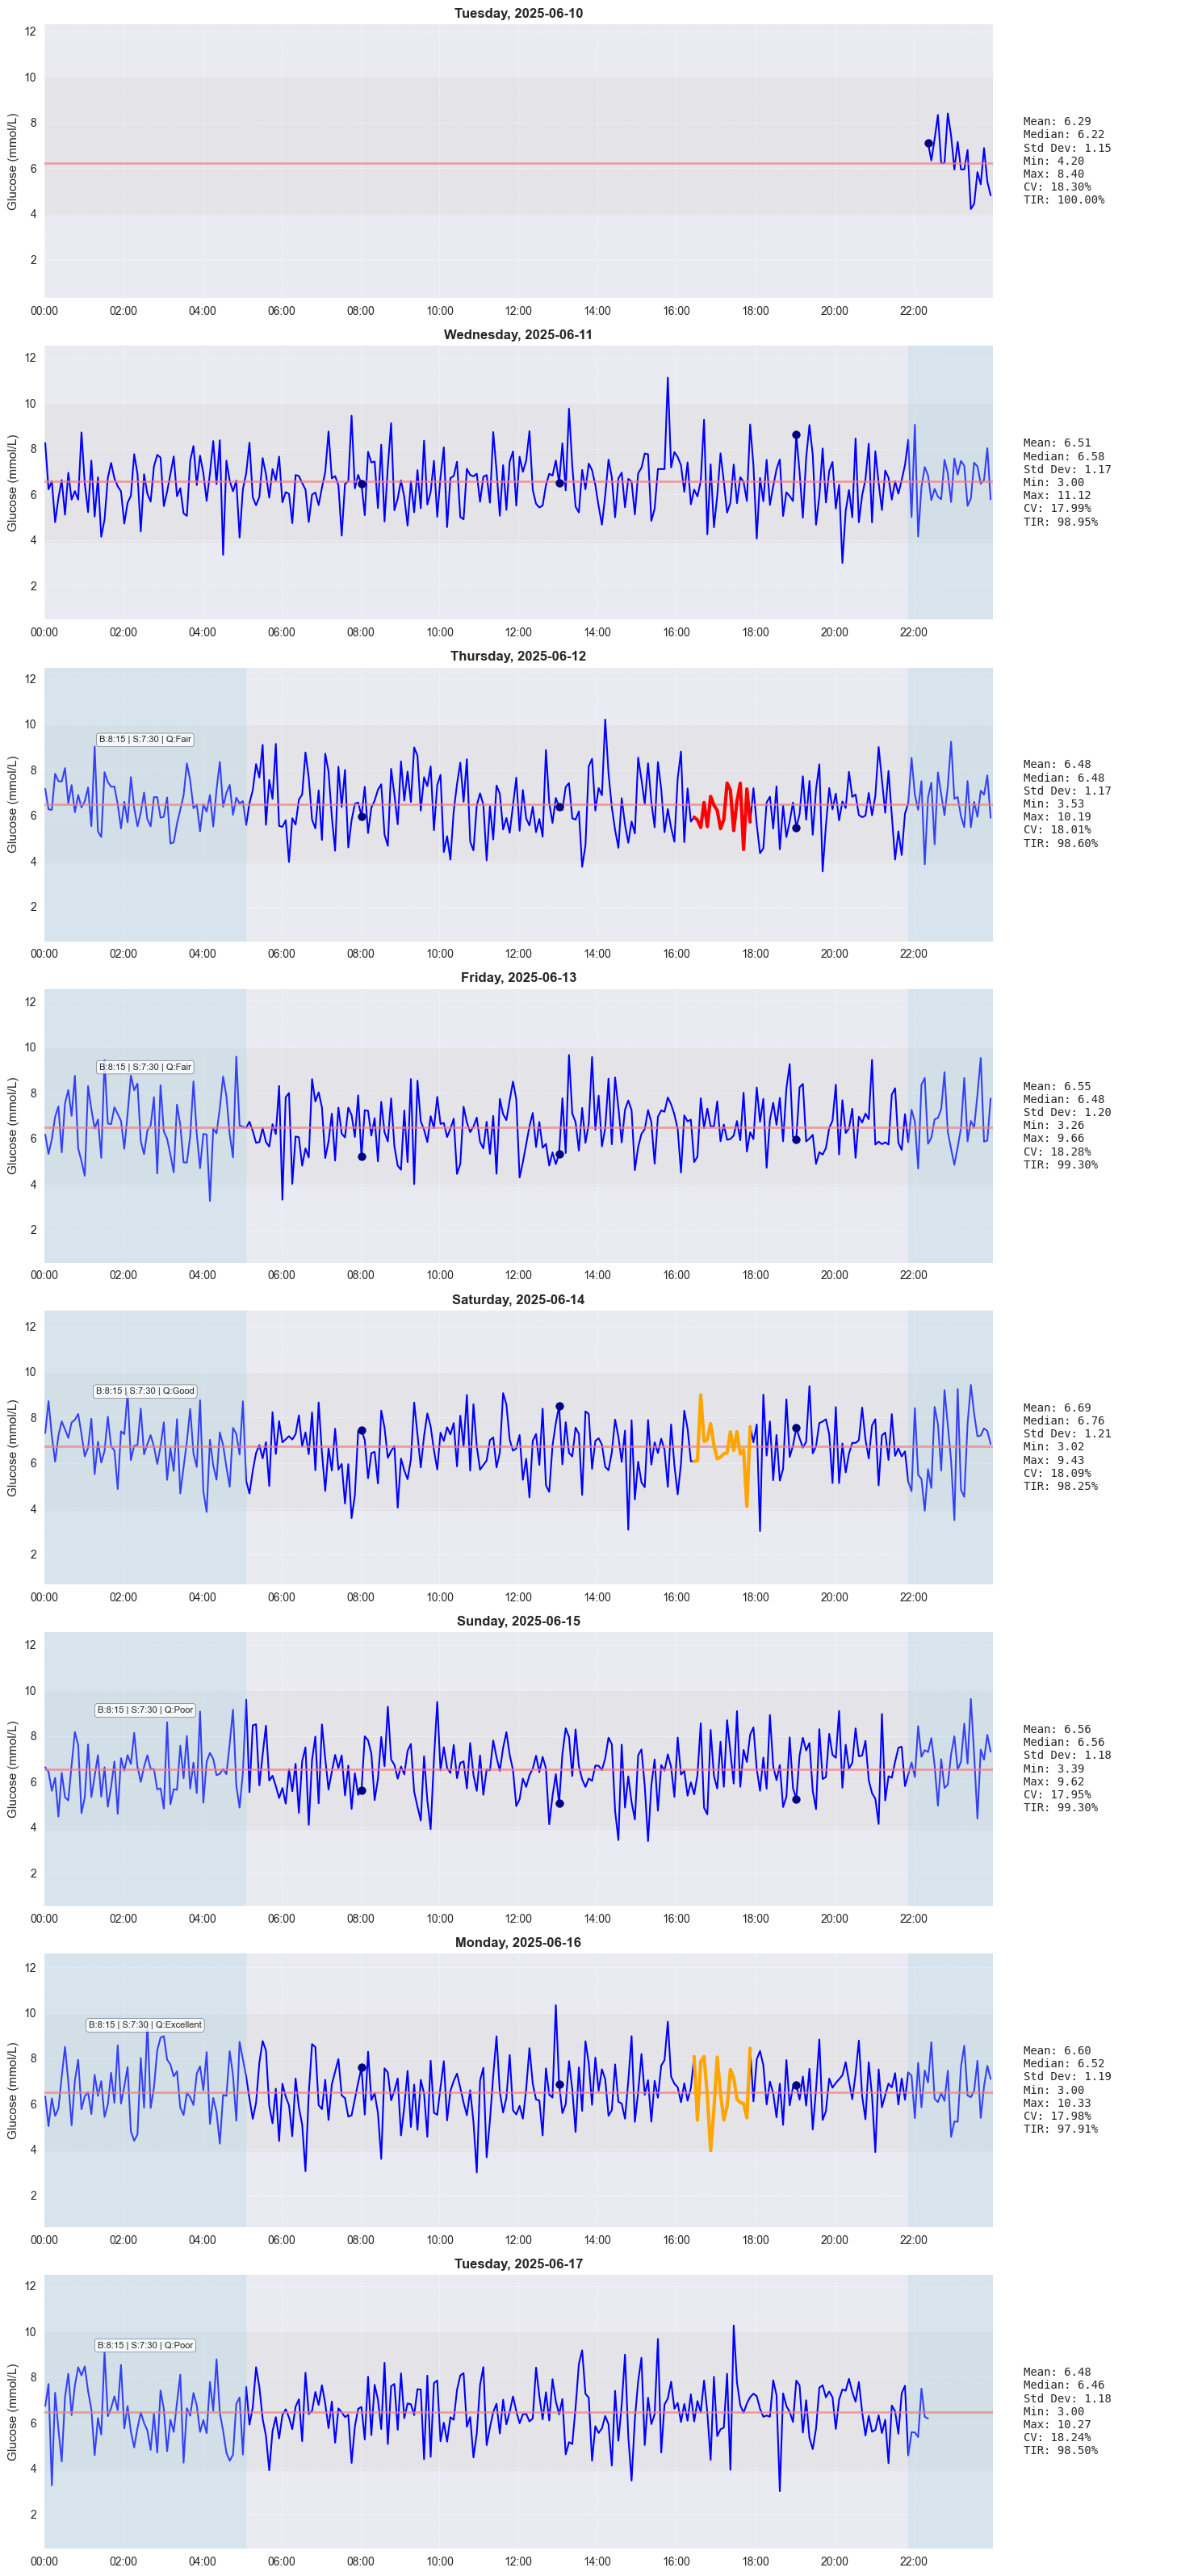

In [7]:
if not glucose_df.empty:
    # Get the date range from glucose data
    start_date = glucose_df.index.min().date()
    end_date = glucose_df.index.max().date()
    num_days = (end_date - start_date).days + 1
        
    print(f"\nDataset covers: {start_date} to {end_date}")
    print(f"Total days: {num_days}")
    
# Create dashboard for the entire dataset
    fig, df_combined = create_glucose_dashboard_from_dfs(
        df_glucose=glucose_df,
        df_nutrition=nutrition_df,
        df_workout=workout_df, 
        df_sleep=sleep_df,
        start_date=start_date,  
        num_days=num_days    
    )
    
plt.show()

In [12]:
# Export analysis results
def export_analysis_results():
    """Export analysis results to files"""
    
    # Create summary statistics
    glucose_data = glucose_df['Historic Glucose mmol/L'].dropna()
    
    summary_stats = {
        'metric': [
            'Mean Glucose (mmol/L)',
            'Median Glucose (mmol/L)',
            'Standard Deviation',
            'Coefficient of Variation (%)',
            'Time in Target Range (%)',
            'Time Below Target (%)',
            'Time Above Target (%)'
        ],
        'value': [
            glucose_data.mean(),
            glucose_data.median(),
            glucose_data.std(),
            (glucose_data.std() / glucose_data.mean() * 100),
            (((glucose_data >= GLUCOSE_TARGET_RANGE[0]) & 
              (glucose_data <= GLUCOSE_TARGET_RANGE[1])).sum() / len(glucose_data) * 100),
            ((glucose_data < GLUCOSE_TARGET_RANGE[0]).sum() / len(glucose_data) * 100),
            ((glucose_data > GLUCOSE_TARGET_RANGE[1]).sum() / len(glucose_data) * 100)
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    
    # Export to CSV
    summary_df.to_csv(OUTPUT_DIR / 'glucose_analysis_summary.csv', index=False)
    
    # Export hourly averages
    hourly_avg = glucose_data.groupby(glucose_data.index.hour).agg([
        'mean', 'std', 'min', 'max', 'count'
    ])
    hourly_avg.to_csv(OUTPUT_DIR / 'hourly_glucose_patterns.csv')
    
    # Export daily summaries
    daily_stats = glucose_data.groupby(glucose_data.index.date).agg([
        'mean', 'std', 'min', 'max', 'count'
    ])
    daily_stats.to_csv(OUTPUT_DIR / 'daily_glucose_summary.csv')
    
    return summary_df

# Export results
summary_results = export_analysis_results()
display(summary_results)

,metric,value
0,Mean Glucose (mmol/L),6.549971
1,Median Glucose (mmol/L),6.542316
2,Standard Deviation,1.184363
3,Coefficient of Variation (%),18.081959
4,Time in Target Range (%),98.710957
5,Time Below Target (%),1.090729
6,Time Above Target (%),0.198314


In [13]:
# Generate final summary report
print("📋 GLUCOSE TRACKING ANALYSIS SUMMARY")
print("=" * 50)
print(f"📅 Analysis Period: {glucose_df.index.min().date()} to {glucose_df.index.max().date()}")
print(f"📊 Total Glucose Readings: {len(glucose_df['Historic Glucose mmol/L'].dropna()):,}")
print(f"⏱️ Data Collection Days: {(glucose_df.index.max() - glucose_df.index.min()).days}")
print("\n🎯 KEY METRICS:")
for _, row in summary_results.iterrows():
    if 'Time' in row['metric']:
        print(f"   {row['metric']}: {row['value']:.1f}%")
    else:
        print(f"   {row['metric']}: {row['value']:.2f}")

📋 GLUCOSE TRACKING ANALYSIS SUMMARY
📅 Analysis Period: 2025-06-10 to 2025-06-17
📊 Total Glucose Readings: 2,017
⏱️ Data Collection Days: 7

🎯 KEY METRICS:
   Mean Glucose (mmol/L): 6.55
   Median Glucose (mmol/L): 6.54
   Standard Deviation: 1.18
   Coefficient of Variation (%): 18.08
   Time in Target Range (%): 98.7%
   Time Below Target (%): 1.1%
   Time Above Target (%): 0.2%
